# Diffusion Model (UViT) with triangles

## Imports

In [1]:
from collections.abc import Callable, Mapping

import inspect

import functools

from clu import metric_writers
import numpy as np
import jax
import flax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn


# this is the package to get the guidance
import jax_fd
import near_field

import gc
import os
import sys

2024-06-14 14:59:50.714359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training process

### Training Dataset

In [2]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Number of training datapoints.
NTRAIN = 21000

# Number of testing datapoints.
NTEST = 500

# Total number
NTOTAL = NTRAIN + NTEST

In [3]:
name = 'Data/traindata_3510tri'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_re = np.stack((tmp2, tmp3), axis=-1)
    #scatter_re = tmp1
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTRAIN, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTRAIN, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_im = np.stack((tmp2, tmp3), axis=-1)
    #scatter_im = tmp1

    # Combine real and imaginary parts
    scatter_ = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
scatter = np.swapaxes(np.swapaxes(np.swapaxes(scatter_,1,2),2,3),3,4)
assert scatter.shape == (NTRAIN, 80, 80, 3, 2)

In [5]:
scatter_train = np.reshape(scatter[:,:,:],(NTRAIN,80,80,6))
eta_re_train = np.array([eta_re[:,:,:]])
eta_re_train = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_train,0,1),1,2),2,3)
assert eta_re_train.shape == (NTRAIN, 80, 80, 1)
assert scatter_train.shape == (NTRAIN, 80, 80, 6)

In [6]:
scatter_train_norm = scatter_train - np.mean(scatter_train,axis=0)

In [7]:
eta_re_train_norm = eta_re_train - np.mean(eta_re_train,axis=0)

In [8]:
assert eta_re_train_norm.shape == (NTRAIN, 80, 80, 1)
assert scatter_train_norm.shape == (NTRAIN, 80, 80, 6)

In [9]:
# To avoid tf to use GPU memory
tf.config.set_visible_devices([], device_type='GPU')

batch_size = 16
dict_data = {"x": eta_re_train_norm}
dict_data["cond"] = {"channel:scatter": scatter_train_norm}
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-06-14 15:00:14.833052: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
data_std = np.std(eta_re_train_norm)
data_size = len(eta_re_train_norm)

### Architecture

In [11]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=data_std,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [12]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=data_std,
)

cond_model = dfn.DenoisingModel(
    input_shape=(80, 80, 1),
    # `cond_shape` must agree with the expected structure and shape
    # (without the batch dimension) of the `cond` input.
    cond_shape={"channel:scatter": (80, 80, 6)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=data_std),
)

In [ ]:
# rm -R -f $cond_workdir  # optional: clear the working directory

In [13]:
epochs = 120
num_train_steps = data_size * epochs // batch_size  #@param
cond_workdir = os.path.abspath('') + "/tmp/diffusion_conditional_triangles_final"
initial_lr = 1e-5 #@param
peak_lr = 5e-4 #@pawram
warmup_steps = num_train_steps // 20  #@param
end_lr = 5e-8 #@param
ema_decay = 0.999  #@param
ckpt_interval = 2000 #@param
max_ckpt_to_keep = 3 #@param

### Training

In [14]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

In [15]:
templates.run_train(
    train_dataloader=dataset,
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions( 
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/157500 [00:00<?, ?step/s]

## Inference
### Test Dataset

In [14]:
# loading test data
NTEST = 500
name = 'Data/testdata_3510tri'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTEST, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re_t = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTEST)]).astype('float32')

# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTEST, :].reshape((-1, nx, nx))
    tmp2 = f[keys[4]][:NTEST, :].reshape((-1, nx, nx))
    tmp3 = f[keys[5]][:NTEST, :].reshape((-1, nx, nx))
    scatter_re = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_re = np.stack((tmp2, tmp3), axis=-1)
    #scatter_re = tmp1
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTEST, :].reshape((-1, nx, nx))
    tmp2 = f[keys[1]][:NTEST, :].reshape((-1, nx, nx))
    tmp3 = f[keys[2]][:NTEST, :].reshape((-1, nx, nx))
    scatter_im = np.stack((tmp1, tmp2, tmp3), axis=-1)
    #scatter_im = np.stack((tmp2, tmp3), axis=-1)
    #scatter_im = tmp1

    # Combine real and imaginary parts
    scatter_t = np.stack((scatter_re, scatter_im), axis=1).astype('float32')

# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [15]:
scattert = np.swapaxes(np.swapaxes(np.swapaxes(scatter_t,1,2),2,3),3,4)
scatter_test = np.reshape(scattert[:,:,:],(NTEST,80,80,6))
eta_re_test = np.array([eta_re_t[:,:,:]])
eta_re_test = np.swapaxes(np.swapaxes(np.swapaxes(eta_re_test,0,1),1,2),2,3)

In [ ]:
# Uncomment to add noise to the scatter conditional
#scatter_test = scatter_test + 0.2*np.random.normal(size=scatter_test.shape)

In [16]:
scatter_test_norm = scatter_test - np.mean(scatter_train,axis=0)

In [17]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)

In [18]:
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

del trained_state

In [19]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(80, 80, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

In [20]:
num_samples_per_cond = 10
num_samples_per_cond_total = 100

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [21]:
batch_size_test = 20
dict_data_test = {}
dict_data_test["cond"] = {"channel:scatter": scatter_test_norm}
dataset_test = tf.data.Dataset.from_tensor_slices(dict_data_test)
dataset_test = dataset_test.batch(batch_size_test)
dataset_test = dataset_test.prefetch(tf.data.AUTOTUNE)
dataset_test = dataset_test.as_numpy_iterator()

In [22]:
eta_pred = np.zeros((NTEST, num_samples_per_cond_total, neta, neta, 1))

b = 0
for batch in dataset_test:
    for i in range(10):
        cond_samples = jax.device_get(jax.vmap(generate, in_axes=(0, 0, None))(
            jax.random.split(jax.random.PRNGKey(888+i), batch_size_test),
            batch["cond"],
            None,  # Guidance inputs = None since no guidance transforms involved
        ))
        eta_pred[b*batch_size_test:(b+1)*batch_size_test,i*num_samples_per_cond:(i+1)*num_samples_per_cond,:,:,:] = cond_samples+np.mean(eta_re_train,axis=0)
    b += 1

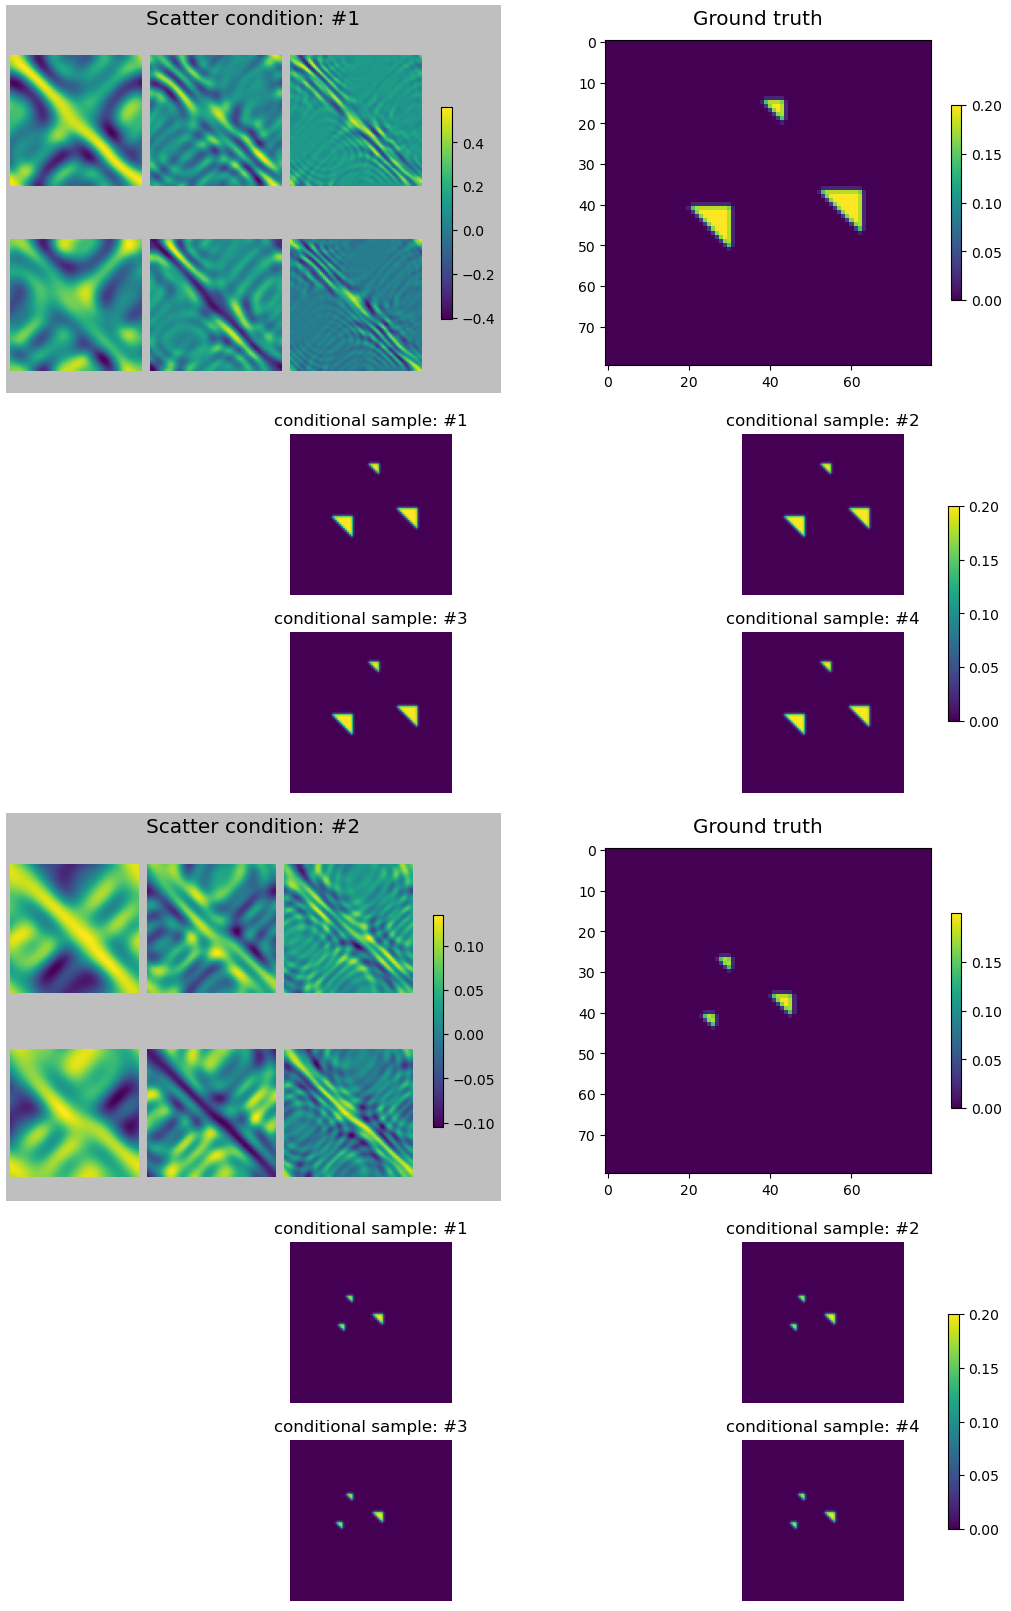

In [23]:
num_samples_per_cond_plot = 4
fig = plt.figure(layout='constrained', figsize=(10, 16))
subfigs = fig.subfigures(2, 1, wspace=0.07)
for i in range(2):
    #subfig = fig.subfigures(layout='constrained', figsize=(10, 4))
    subfigsnest = subfigs[i].subfigures(2, 1)#, wspace=0.1)
    #print(subfigs.shape)
    subfigsnest1 = subfigsnest[0].subfigures(1, 2)#, height_ratios=[1, 1.4])
    axsLeft = subfigsnest1[0].subplots(2,3)
    subfigsnest1[0].set_facecolor('0.75')
    l = 0
    for k in range(3):
        for j in range(2):
            im = axsLeft[j,k].imshow(scatter_test[i, :, :, l])#,vmin=-2.5, vmax=2.5)
            #print(test_batch_cond_denorm[i, :, :, l].shape)
            l += 1
            axsLeft[j,k].axis("off")
    subfigsnest1[0].suptitle(f"Scatter condition: #{i + 1}", fontsize='x-large')
    subfigsnest1[0].colorbar(im,shrink=0.6, ax=axsLeft, location='right')
    
    axsRight = subfigsnest1[1].subplots(1, 1)
    im_eta = axsRight.imshow(eta_re_test[i, :, :, 0])
    
    #subfigs[1].set_facecolor('0.85')
    #subfigs[1].colorbar(pc, shrink=0.6, ax=axsRight)
    subfigsnest1[1].suptitle('Ground truth', fontsize='x-large')
    subfigsnest1[1].colorbar(im_eta,shrink=0.6, ax=axsRight)
    #fig.suptitle('Scatter and ground truth', fontsize='xx-large')
    
    # Plot generated samples.
    ax = subfigsnest[1].subplots(
              2, int(num_samples_per_cond_plot/2))#, figsize=(num_samples_per_cond_plot*2, 4))
    l = 0
    for k in range(2):
        for j in range(int(num_samples_per_cond_plot/2)):
            im = ax[k,j].imshow(eta_pred[i,l,:,:,0])
                 #cond_samples_denorm_[i, l, :, :, 0])#, vmin=0, vmax=2.5)
            ax[k,j].set_title(f"conditional sample: #{l+1}")
            ax[k,j].axis("off")
            l += 1
    subfigsnest[1].colorbar(im, ax=ax[:,:], shrink=0.6, location="right")
        
    #plt.tight_layout()
#fig.savefig('cond_smooth_sigma_0.04_freq_2.5.png')
plt.show()

### Writing files for restults

In [24]:
with h5py.File("Results/results_diffusion_triangles_freq_2.5_5_10.hdf5", "w") as f:
    eta = f.create_dataset('eta', data=eta_re_test)
    eta_predicted = f.create_dataset('eta_pred', data=eta_pred)